In [1]:
import spotipy, pandas as pd, json, numpy as np
from spotipy.oauth2 import SpotifyOAuth
from sklearn import preprocessing as pre
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

In [2]:
scope = 'playlist-modify-public playlist-modify-private'
red_url = 'http://localhost:8080'
playlist = 'https://open.spotify.com/playlist/0zZlkqz8ZRPsZd0kARwia9?si=a6ee70de66014a4c'

sp = spotipy.Spotify(auth_manager=SpotifyOAuth(redirect_uri=red_url,scope=scope))

In [3]:
offset = 0
song_ids = []
while True:
    songs = sp.playlist_tracks(playlist_id=playlist, offset=offset, fields='items.track.id', limit=100)['items']
    if len(songs) == 0:
        break
    song_ids += [d['track']['id'] for d in songs]
    offset = offset + len(songs)

In [4]:
offset = 0
limit = 50
song_feats = []
while offset < len(song_ids):
    song_feats += sp.audio_features(tracks=song_ids[offset: offset + limit])
    offset += limit

In [5]:
# aud_anal = []
# aud_secs = []
# j = 0
# for song in song_ids:
#     track = sp.audio_analysis(song_ids[j])
#     dur = track['track']['duration']
#     secs = len(track['sections'])
#     aud_anal.append(track)
#     aud_secs.append(60*secs/dur)
#     j += 1

In [6]:
df_feats = pd.DataFrame(song_feats).drop(['type', 'uri', 'track_href', 'analysis_url', 'duration_ms'], axis=1)
# df_aud = pd.DataFrame(aud_anal)[['tempo_confidence','time_signature_confidence','key_confidence','mode_confidence']]
# df_secs = pd.DataFrame({'secs/min': aud_secs})

In [7]:
# df_dummies = pd.get_dummies(df_feats[['key', 'time_signature']], columns=['key', 'time_signature'], drop_first=True)

In [8]:
to_norm = df_feats[['loudness', 'tempo', 'speechiness', 'acousticness', 'instrumentalness', 'liveness']].values
scaler = pre.MinMaxScaler()
normed = scaler.fit_transform(to_norm)
df_normed = pd.DataFrame(normed).rename(columns={0: 'loudness_normed', 1: 'tempo_normed', 2: 'speechiness', 3: 'acousticness', 4: 'instrumentalness', 5: 'liveness'})

In [9]:
df_feats.drop(['loudness', 'tempo', 'speechiness', 'acousticness', 'instrumentalness', 'liveness'], axis=1, inplace=True)

In [10]:
df_feats = df_feats.join(df_normed).set_index('id')

In [11]:
n_clusters = [2, 3, 4, 5, 6]
cluster_scores = []
for n in n_clusters:
    clusters = KMeans(n_clusters=n)
    labs = clusters.fit_predict(df_feats.values)
    sil_avg = silhouette_score(df_feats.values, labs)
    cluster_scores.append(sil_avg)

In [12]:
cluster_scores

[0.5860510605907138,
 0.5215521173681256,
 0.46080950686541705,
 0.4111563705644739,
 0.3226681734057258]

In [13]:
clustered = KMeans(n_clusters=cluster_scores.index(max(cluster_scores))+2)

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


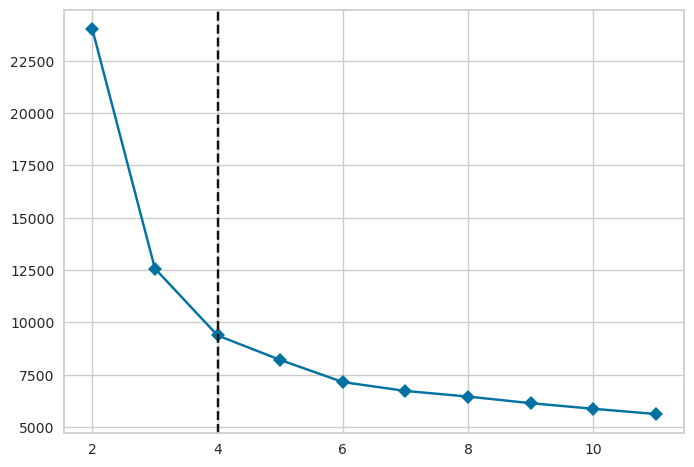

In [14]:
mod = KMeans()
visualizer = KElbowVisualizer(mod, k=(2,12), timings=False)
visualizer.fit(df_feats.values)
value = visualizer.elbow_value_